# Project 3 - WEB APIs and NLP Classification - Subreddits
# Part 1 - Data Scraping, Cleaning and EDA

## Problem Statement

[Natural Language Processing (NLP)](https://en.wikipedia.org/wiki/Natural_language_processing) is a hyponym of computer science and artificial intelligence that focus on the interactions between computers and natural human languages like English, for example. Ultimately the purpose of NLP is to read, understand and decipher human languages in a way that it is valuable.

In this project, we will be using NLP to distinguish posts from two subreddit posts i.e. r/datascience and r/SoftwareEngineering. To solve this binary classfication problem will also be looking at mulitple supervised machine learning models to help us distinguish our posts. However, with numerous machine learning models, how do we decide which model is the best to help us in our task?


*Problem Statement: Which classfication model can best distinguish which subreddit a post belongs to?*


We will be looking at various evaluation metrics for classifications models, such as the train and test accuracy scores, precision and recall scores, f1-score, and the ROC AUC score to evaluate the performances of our models and both the train and test data and pick the best model that caters to our task.

This project will be split into two notebooks:

Part 1 - Data Scraping, Cleaning and EDA

Part 2 - Modelling and Evaluation

## Data Scraping

The dataset for both subreddits was extracted using Reddit's API that allowed for 1000 posts to be extracted per day. Reddit only provides up to 25 posts each time, hence a for loop was used to hit the API multiple times to extract at least 1000 posts, including the use of time.sleep() function to allow for breaks between requests.

Result:

For the r/datascience subreddit, we managed to extract 1016 posts and for the r/SoftwareEngineering we managed to extract 1008 posts. 

The entire data scraping process can be found in the appendix titled as 'Data Scraping - Appendix' Notebook.
The raw datasets can be found in the 'data' folder titled as 'datascience.csv' and 'softwareengin.csv' respectively. We will be using these datasets for the rest of the project.

## Data Cleaning

Let us import all the libraries that we need for this notebook and read in our datasets.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup
import re as re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [2]:
ds = pd.read_csv(
    './data/datascience.csv',
    usecols=['subreddit', 'selftext', 'title', 'author']
)
se= pd.read_csv(
    './data/softwareengin.csv', 
    usecols=['subreddit', 'selftext', 'title', 'author']
)

Let's look at an overview of our subreddit datasets.

In [3]:
ds.head(10)

,subreddit,selftext,title,author
0,datascience,Welcome to this week's entering &amp; transiti...,Weekly Entering &amp; Transitioning Thread | 1...,datascience-bot
1,datascience,"Hi Everyone, I am an industry data scientist. ...",What are some exciting new tools/libraries in ...,nyc_brand
2,datascience,NaN,"Python or R, which programming language is bet...",iam_syndrome
3,datascience,"I am a beginner and have learned Python, Panda...","What tools, language and technologies to learn...",Emperor-SuN-5
4,datascience,I read a lot of posts about how to land a data...,Some tips on how to go from academia to a Data...,_StunningStar_
5,datascience,Github link (includes a link to a Kaggle noteb...,ML Optimizers from scratch using JAX,shreyansh26
6,datascience,"Hi,\n\nI have posted this on other subreddits ...",What approach do I use to analyze this F&amp;B...,Professional_Crazy49
7,datascience,"Hi,\n\nI have a dataset containing the monthly...",Crossvalidation using Facebook Prophet,xnxrxdh
8,datascience,Hey guys. Hope you are doing good today.\n\nI ...,Full Data engineering/ Data science Pipeline o...,Shyprogrammer1
9,datascience,I’m considering a switch to data engineering a...,"Data Scientists who switched to Data Engineer,...",Dismal-Variation-12


In [4]:
se.head(10)

,subreddit,selftext,title,author
0,SoftwareEngineering,# General\n\nThis is a place where high-level ...,Subreddit Guidelines,Tred27
1,SoftwareEngineering,I know C language does not include array bound...,PHP array bound checking,JEANB0Y
2,SoftwareEngineering,Our single page application (SPA) aims to allo...,Addressing a specific UI component in a web pa...,dacracot
3,SoftwareEngineering,I have a service which can have some stale dat...,Stale data: what should be resolving this?,Forumpy
4,SoftwareEngineering,Hi r/SoftwareEngineering!\n\nI'm curious what ...,What does your development database environmen...,cjheppell
5,SoftwareEngineering,NaN,For all of you who are (or are going to be) so...,explosive_rabbit
6,SoftwareEngineering,NaN,Four Reasons Why Apache Pulsar is Essential to...,nfrankel
7,SoftwareEngineering,I'm looking for book recommendations on the to...,Unusual Book Request,al3xth3gr8
8,SoftwareEngineering,NaN,"Eleven Patterns, Problems &amp; Solutions rela...",nfrankel
9,SoftwareEngineering,I have seen this problem in a couple of projec...,"""Multiple staging systems"" or how do you give ...",antonpirker


### Remove Duplicates

First we will remove all the duplicates in the title and selftext columns in both datasets.

In [5]:
#drop duplicates in title and selftext columns
ds.drop_duplicates(subset = ['title', 'selftext'], inplace = True)
se.drop_duplicates(subset = ['title', 'selftext'], inplace = True)

### Amend Null Values

Next, we are going to amend all null values and combine our title and selftext columns in both datasets.

In [6]:
#fill null values in both datasets
ds.fillna(value = '', inplace = True)
se.fillna(value = '', inplace = True)

In [7]:
#combine text and selftext columns
ds['title_selftext'] = ds['title'] + '' + ds['selftext']
se['title_selftext'] = se['title'] + '' + se['selftext']

### Bots and Moderators

Subreddits have bots and moderators that overlook reddit's community guidelines and publish standardised posts. These posts may not necessarily pertain to the subreddit topics. Let us take a look at the types of moderators and bots.

##### r/datascience

In [8]:
ds[ds['author'].str.contains("bot", "moderator")]

,subreddit,selftext,title,author,title_selftext
0,datascience,Welcome to this week's entering &amp; transiti...,Weekly Entering &amp; Transitioning Thread | 1...,datascience-bot,Weekly Entering &amp; Transitioning Thread | 1...
181,datascience,Welcome to this week's entering &amp; transiti...,Weekly Entering &amp; Transitioning Thread | 0...,datascience-bot,Weekly Entering &amp; Transitioning Thread | 0...
262,datascience,Welcome to this week's entering &amp; transiti...,Weekly Entering &amp; Transitioning Thread | 3...,datascience-bot,Weekly Entering &amp; Transitioning Thread | 3...
342,datascience,Welcome to this week's entering &amp; transiti...,Weekly Entering &amp; Transitioning Thread | 2...,datascience-bot,Weekly Entering &amp; Transitioning Thread | 2...
404,datascience,Welcome to this week's entering &amp; transiti...,Weekly Entering &amp; Transitioning Thread | 1...,datascience-bot,Weekly Entering &amp; Transitioning Thread | 1...
459,datascience,Welcome to this week's entering &amp; transiti...,Weekly Entering &amp; Transitioning Thread | 0...,datascience-bot,Weekly Entering &amp; Transitioning Thread | 0...
508,datascience,Welcome to this week's entering &amp; transiti...,Weekly Entering &amp; Transitioning Thread | 0...,datascience-bot,Weekly Entering &amp; Transitioning Thread | 0...
546,datascience,Welcome to this week's entering &amp; transiti...,Weekly Entering &amp; Transitioning Thread | 2...,datascience-bot,Weekly Entering &amp; Transitioning Thread | 2...
579,datascience,Welcome to this week's entering &amp; transiti...,Weekly Entering &amp; Transitioning Thread | 1...,datascience-bot,Weekly Entering &amp; Transitioning Thread | 1...


As seen above, the author 'datascience-bot' provides weekly posts which are repetitive and not useful to us. Hence we will drop these columns.

In [9]:
index = ds[ds['author'] == 'datascience-bot'].index
ds.drop(index, inplace = True)

##### r/SoftwareEngineering

In [10]:
se[se['author'].str.contains("bot", "moderator")]

,subreddit,selftext,title,author,title_selftext
27,SoftwareEngineering,"I have spoken to dozens of CTO's, Heads of Eng...",What is the biggest issue(s) in the IT industr...,hjbotton,What is the biggest issue(s) in the IT industr...
102,SoftwareEngineering,,"Is there a formal definition for the term ""fac...",Roybot93,"Is there a formal definition for the term ""fac..."
297,SoftwareEngineering,,What is the biggest problem you have faced whe...,hjbotton,What is the biggest problem you have faced whe...
609,SoftwareEngineering,"Hey all, I've been writing software profession...",Looking to collaborate on software projects wi...,Roybot93,Looking to collaborate on software projects wi...


As seen above, there are no bots or moderators in r/SoftwareEngineering. However, from our initial analysis, we saw a quick overview of our software engineering dataframe and found the very first post pertaining to guidelines. Let us take a look at that.

In [11]:
se[se['title'].str.contains("Guidelines")]

,subreddit,selftext,title,author,title_selftext
0,SoftwareEngineering,# General\n\nThis is a place where high-level ...,Subreddit Guidelines,Tred27,Subreddit Guidelines# General\n\nThis is a pla...


In [12]:
se.selftext[0]

'# General\n\nThis is a place where high-level topics are discussed, think not of frameworks, stacks, cloud services but architecture, design paradigms, management practices, etc.\n\n* Always follow the [reddiquette](/wiki/reddiquette) \n* This subreddit is for software engineering-related content in general; try to be "vague" with the specific technology you are using. Software engineering deals with higher-level topics and abstractions.\n* Do not publish career questions; career questions belong to r/cscareerquestions.\n* You can publish your own content if it goes through the moderation team first, and if it\'s tasteful, we won\'t allow posts from accounts that ONLY publish their own content, publish low-effort posts, and cross-post to every subreddit that\'s just a bit related.\n\n#Post Rules\n\n* The following thread types require mod approval: surveys and AMAs (sharing survey results are fine).\n* Low-effort, homework help, "looking to interview." posts are not allowed.\n* Don\'t

There is only 1 post that contains "Guidelines" and when we look deeper into its 'selftext' we see that the post indeed talks about the guidelines and rules towards posting in this subreddit. Hence we will drop this post as well.

In [13]:
se.drop(index = 0, inplace = True)

## EDA

### Preprocessing

The posts extracted from reddit's site contain may stop words, links, html tags and other characters that are not useful in our analysis. Hence we will preprocess them and proceed to clean our data. As we have already combined our datasets and our 'title' and 'selftext' columns, we will only clean our 'title_selftext' column instead hence cleaning the entire combined dataset will clean other columns like 'author' too which we want to preserve.

In [14]:
#create list of stopwords
my_stopwords = ['datascience', 'ds', 'softwareengineering','se', 'software', 'data', 'scientist', 'lot', 
                'engineer', 'science','www', 'reddit', 'com', 'like', 'use', 'know', 'make', 'look',
                'get', 'want', 'would', 'one', 'go', 'also', 'new', 'much']

comb_stopwords = set(my_stopwords + stopwords.words('english')) 

#lemmatise and stem stopwords
p_stemmer = PorterStemmer()
cleaned_stopwords = [p_stemmer.stem(i) for i in comb_stopwords]

We are going to create a function to preprocess the 'title_selftext' feature in both datasets.

In [15]:
def text_preprocessor(temp_list):
    #empty list to store output
    cleaned_temp = []
    #loop through list and remove tags, urls , nonalphanumeric and next line characters
    for strings in temp_list:

        cleaned_words = []
    
        #Remove html tags
        removed_tags = BeautifulSoup(strings).get_text()
    
        #remove urls
        removed_urls = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', 
                              ' ', removed_tags, flags=re.MULTILINE)
    
        #remove nonalphanumeric and other characters
        removed_char = re.sub('[\W\\n]', ' ', removed_urls)
    
        #convert to lowercase and split values
        lowercase_words = removed_char.lower().split()
        
        #remove stopwords
        removed_stopwords = [w for w in lowercase_words if w not in comb_stopwords]
    
        #lemmatise and stem words and remove from stemmed stopwords list
        stemmed_words = [p_stemmer.stem(i) for i in removed_stopwords]
        cleaned_words = [w for w in stemmed_words if w not in cleaned_stopwords]

         
        #join words back into one string with separated space and store in list
        temp_string = " ".join(cleaned_words)
        cleaned_temp.append(temp_string)
        
    return cleaned_temp

In [16]:
#preprocess 'title_selftext' feature
ds_processed_list = text_preprocessor(ds['title_selftext'].tolist())
se_processed_list = text_preprocessor(se['title_selftext'].tolist())

In [17]:
#add the 'title_selftext' feature back to df and drop remaining columns
ds.drop(columns = ['selftext', 'title', 'title_selftext'], inplace = True)
se.drop(columns = ['selftext', 'title', 'title_selftext'], inplace = True)
ds['text_cleaned'] = pd.Series(ds_processed_list).values
se['text_cleaned'] = pd.Series(se_processed_list).values

### Bag of N-grams

In [18]:
#function to plot various ngrams
def barplot(ngram):

    #top 20 words for a sequence of n tokens for r/datascience
    cvec = CountVectorizer(ngram_range=ngram)
    matrix = cvec.fit_transform(ds['text_cleaned'])
    frequency = zip(cvec.get_feature_names(), matrix.sum(axis=0).tolist()[0])
    ds_list = sorted(frequency, key = lambda x: -x[1])[:20]
    
    #top 20 words for a sequence of n tokens for r/SoftwareEngineering
    cvec = CountVectorizer(ngram_range=ngram)
    matrix = cvec.fit_transform(se['text_cleaned'])
    frequency = zip(cvec.get_feature_names(), matrix.sum(axis=0).tolist()[0])
    se_list = sorted(frequency, key = lambda x: -x[1])[:20]
    
    fig, ax = plt.subplots(1, 2, figsize= (15,12)) #for both subreddits
    ax = ax.ravel()
    
    #datascience ngram barplot
    sns.barplot(data = pd.DataFrame.from_records(ds_list, columns = ['ngram', 'frequency']),
                x ='frequency',
                y ='ngram',
                ax = ax[0],
                palette="rocket")
    ax[0].set_title(f'Top 20 {ngram} n-grams for r/datascience', fontsize=14)
    
    #softwareengineering ngram barplot
    sns.barplot(data = pd.DataFrame.from_records(se_list, columns = ['ngram', 'frequency']),
                x ='frequency',
                y ='ngram',
                ax = ax[1],
                palette="mako")
    ax[1].set_title(f'Top 20 {ngram} n-grams for r/SoftwareEngineering', fontsize=14)
    
    fig.tight_layout()

#### 1-grams Barplot

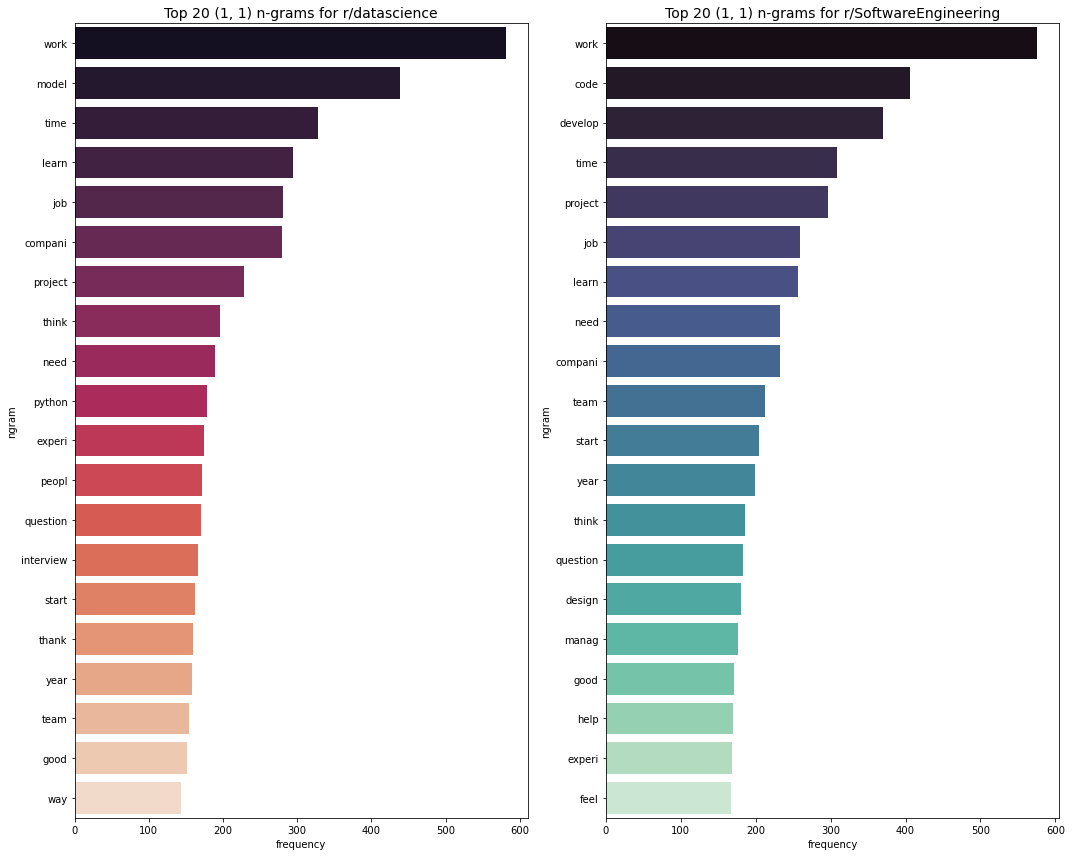

In [19]:
barplot((1,1))

#### 2-grams Barplot

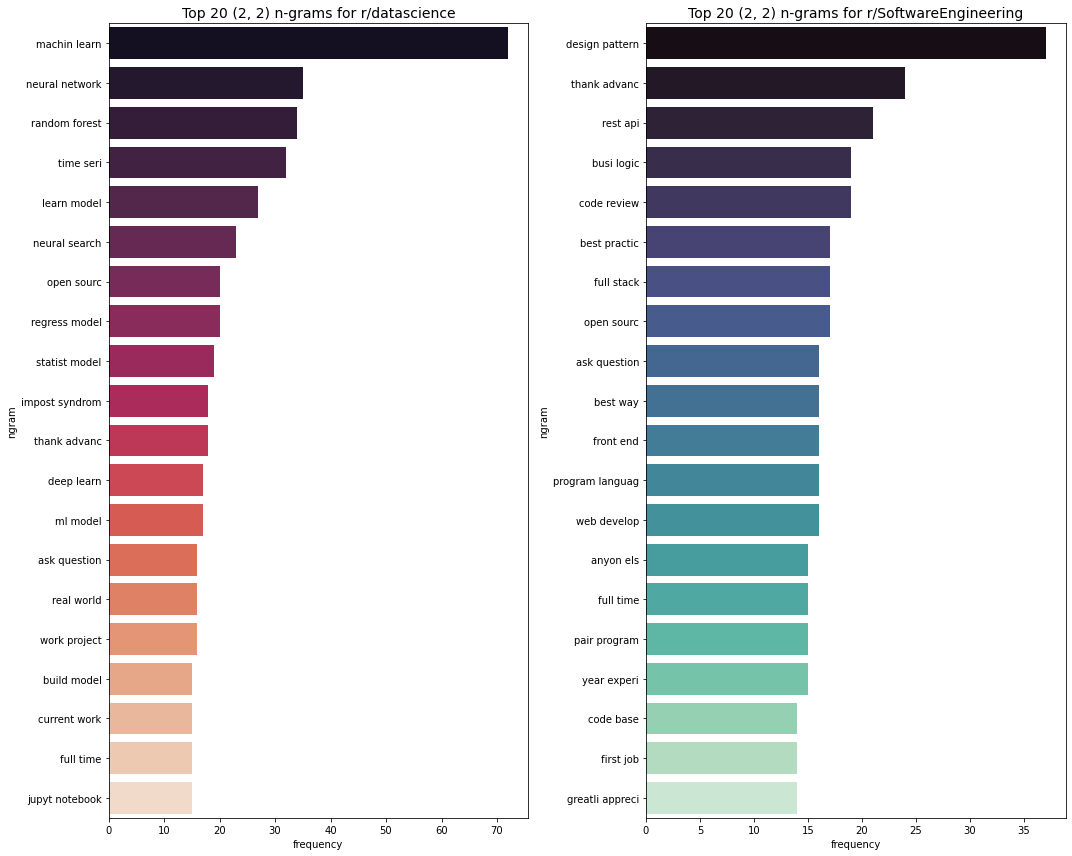

In [20]:
barplot((2,2))

#### 3-grams Barplot

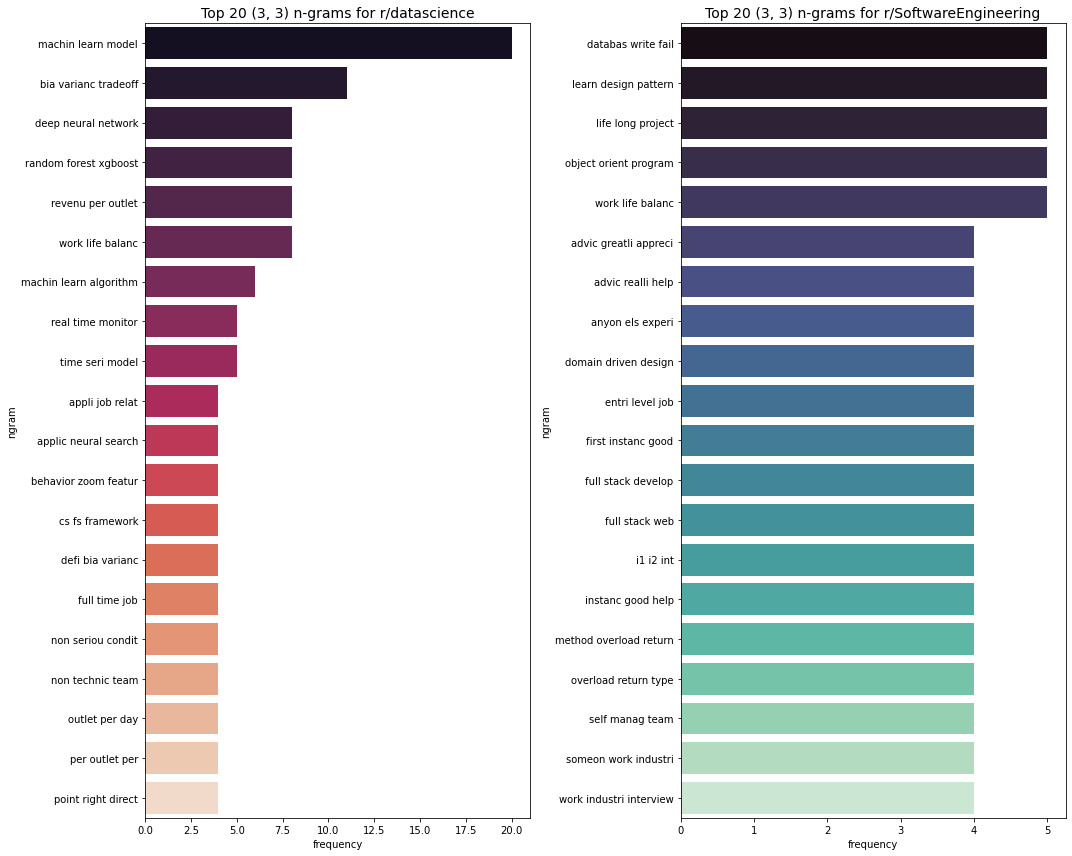

In [21]:
barplot((3,3))

### Combining datasets and Converting Binary Labels

We are first going to merge our reddit posts from both subreddits into 1.

In [22]:
#merging both datasets
combined = pd.concat([ds, se], axis =0, ignore_index = True)

Then, we are going to convert our subreddit titles to binary labels

    - 0 for datascience
    - 1 for SoftwareEngineering

In [23]:
#convert subreddit column to binary and rename to label
combined['subreddit'] = combined['subreddit'].map({'datascience': 0, 'SoftwareEngineering': 1})
combined.rename(columns = {'subreddit': 'label'}, inplace = True)

Export our cleaned dataset into csv file.

In [24]:
combined.to_csv('./data/combined_cleaned.csv', index = False)

This is the end of the first notebook. Please refer to 'Part 2 - Modelling and Evaluation' for the next part of this project.